In [2]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

In [3]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

In [4]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9233879.07it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174862.15it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3295063.12it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6395816.64it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
def initialize_weights(m):
  """
  Initialize the weights and biases of the model.
  """
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      torch.nn.init.kaiming_uniform_(m.weight)
      torch.nn.init.uniform_(m.bias)

model.apply(initialize_weights)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
model = vgg16(pretrained = True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=10)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True
initialize_weights(model.classifier[-1])

In [9]:
model = model.cuda()

criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
num_epochs = 10

# Define lists to store training and validation losses
train_losses = []
accuracy = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in training_dataloader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = model.forward(inputs)
      loss = criterion(output, labels)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # Compute average training loss for the epoch
    avg_train_loss = train_loss / len(training_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')


    ########################### Test #####################################
    # TODO: Design your own Test section
    model.eval()
    test_loss = 0.0
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
          inputs = inputs.cuda()
          labels = labels.cuda()
          output = model(inputs)
          loss = criterion(output, labels)
          test_loss += loss.item()
          predict = output.argmax(axis=1)
          test_correct += (predict == labels).float().sum()

    avg_test_loss = test_loss / len(test_dataloader.dataset)
    test_accuracy = test_correct / len(test_dataloader.dataset)
    accuracy.append(test_accuracy.item())
    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Start Training...

EPOCH 1 of 10

Epoch [1/10], Train Loss: 0.9955
Test Loss: 0.0190
Test Accuracy: 0.7926

EPOCH 2 of 10

Epoch [2/10], Train Loss: 0.6827
Test Loss: 0.0173
Test Accuracy: 0.8063

EPOCH 3 of 10

Epoch [3/10], Train Loss: 0.6283
Test Loss: 0.0165
Test Accuracy: 0.8137

EPOCH 4 of 10

Epoch [4/10], Train Loss: 0.5976
Test Loss: 0.0160
Test Accuracy: 0.8193

EPOCH 5 of 10

Epoch [5/10], Train Loss: 0.5803
Test Loss: 0.0156
Test Accuracy: 0.8246

EPOCH 6 of 10

Epoch [6/10], Train Loss: 0.5627
Test Loss: 0.0153
Test Accuracy: 0.8271

EPOCH 7 of 10

Epoch [7/10], Train Loss: 0.5528
Test Loss: 0.0150
Test Accuracy: 0.8298

EPOCH 8 of 10

Epoch [8/10], Train Loss: 0.5411
Test Loss: 0.0148
Test Accuracy: 0.8305

EPOCH 9 of 10

Epoch [9/10], Train Loss: 0.5362
Test Loss: 0.0146
Test Accuracy: 0.8362

EPOCH 10 of 10

Epoch [10/10], Train Loss: 0.5284
Test Loss: 0.0145
Test Accuracy: 0.8367


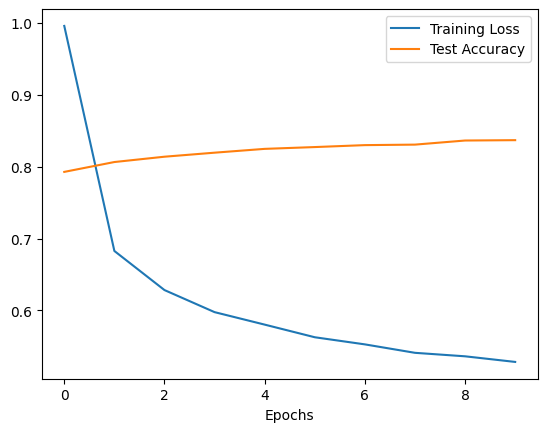

In [10]:
fig = plt.figure() # create the canvas for plotting
ax = plt.subplot()
ax.plot(train_losses, label = "Training Loss")
ax.plot(accuracy, label = "Test Accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Epochs")
ax.legend(handles, labels)